In [1]:
#import necessary modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\Arko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Arko\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#read the model ready data and separate the train and test data
#Also get the Survived column from original train data since the same was removed during pre-processing
def getdata(data):
    response = pd.read_csv("C:/Users/Arko/Downloads/Studies/PersonalResearch/TitanicData/train.csv", usecols = ['Survived'])
    #Convert ndarray to 1d array
    response = np.array(response).ravel()
    traindata = data[data['Identifier']=="Train"]
    testdata = data[data['Identifier']=="Test"]
    #drop the Identifier columns
    traindata.drop("Identifier",axis = 1,inplace = True)
    testdata.drop("Identifier",axis = 1,inplace = True)
    return response,traindata,testdata

In [3]:
processedData = pd.read_csv("C:/Users/Arko/Downloads/Studies/PersonalResearch/TitanicData/ModelReadyData.csv")
#print(processedData.columns)
#drop the unnecessary Unnamed column
processedData.drop('Unnamed: 0',axis = 1,inplace = True)
print(processedData.columns)
#invoke the above function
response , traindata, testdata = getdata(processedData)

Index(['PassengerId', 'Sex', 'Age', 'Fare', 'Identifier', 'Title__Master',
       'Title__Miss', 'Title__Mr', 'Title__Mrs', 'Title__Officer',
       'Title__Royalty', 'Pclass__1', 'Pclass__2', 'Pclass__3', 'Embarked__C',
       'Embarked__Q', 'Embarked__S', 'FamilySize', 'Singleton', 'SmallFamily',
       'LargeFamily', 'Cabin__A', 'Cabin__B', 'Cabin__C', 'Cabin__D',
       'Cabin__E', 'Cabin__F', 'Cabin__G', 'Cabin__T', 'Cabin__U'],
      dtype='object')


C:\Users\Arko\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Arko\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
#check the outputs
traindata.head()
testdata.head()
#response

,PassengerId,Sex,Age,Fare,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Officer,Title__Royalty,...,LargeFamily,Cabin__A,Cabin__B,Cabin__C,Cabin__D,Cabin__E,Cabin__F,Cabin__G,Cabin__T,Cabin__U
891,892,1.0,0.430039,0.015282,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
892,893,0.0,0.586622,0.013663,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
893,894,1.0,0.774521,0.018909,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
894,895,1.0,0.336089,0.016908,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
895,896,0.0,0.273456,0.023984,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


        predictors  importances
14            Fare     0.212980
0              Age     0.209440
24       Title__Mr     0.117345
19             Sex     0.113797
13      FamilySize     0.049122
18       Pclass__3     0.038786
23     Title__Miss     0.035921
25      Title__Mrs     0.033951
9         Cabin__U     0.028694
15     LargeFamily     0.021508
16       Pclass__1     0.018522
17       Pclass__2     0.014439
12     Embarked__S     0.014275
10     Embarked__C     0.011308
22   Title__Master     0.010025
5         Cabin__E     0.009691
21     SmallFamily     0.009171
20       Singleton     0.009090
11     Embarked__Q     0.007746
26  Title__Officer     0.007698
3         Cabin__C     0.006754
2         Cabin__B     0.006372
4         Cabin__D     0.006211
1         Cabin__A     0.002799
6         Cabin__F     0.001723
7         Cabin__G     0.001236
27  Title__Royalty     0.001173
8         Cabin__T     0.000223


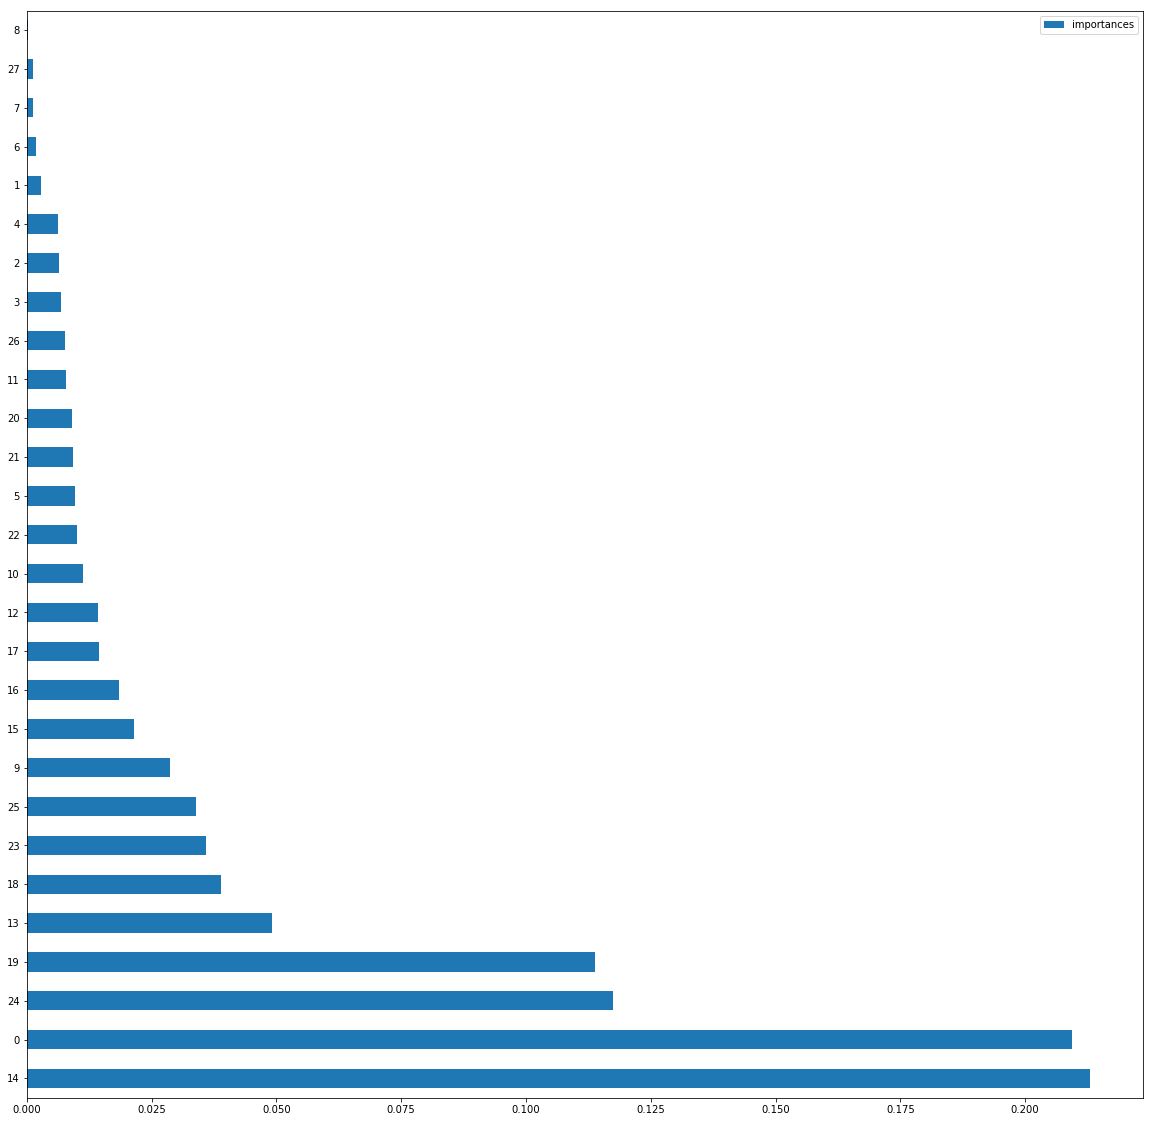

In [5]:
#select features using RandomForest Classifier
#don't consider the PassengerId since it is a feature and not an index
clf = RandomForestClassifier(n_estimators=500, max_features='sqrt')
clf = clf.fit(traindata[traindata.columns.difference(['PassengerId'])], response)
features = pd.DataFrame()
features['predictors'] = traindata[traindata.columns.difference(['PassengerId'])].columns
features['importances'] = clf.feature_importances_
features.sort_values(by = ['importances'],ascending = False,inplace = True)
#features.set_index('predictors',inplace = True)
#print the features with the importances
print(features)
#plot the features to view by importances
features.plot(kind='barh',figsize = (20,20))

In [6]:
#Select the top 80% of the features based on their importances
predictors = features.head(round(len(features.importances)*0.80))['predictors']
#predictors.head()

In [7]:
#Using these features create another RandomForest classifier model on traindata
#This does not involve any tuning. Can be used as a basic implementation
clf = RandomForestClassifier(n_estimators=500, criterion='gini',oob_score = True, n_jobs=3)
clf = clf.fit(traindata[predictors],response)
#predict on test data
testdata['Survived']=clf.predict(testdata[predictors])
testdata.head()

C:\Users\Arko\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PassengerId,Sex,Age,Fare,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Officer,Title__Royalty,...,Cabin__A,Cabin__B,Cabin__C,Cabin__D,Cabin__E,Cabin__F,Cabin__G,Cabin__T,Cabin__U,Survived
891,892,1.0,0.430039,0.015282,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
892,893,0.0,0.586622,0.013663,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
893,894,1.0,0.774521,0.018909,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
894,895,1.0,0.336089,0.016908,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
895,896,0.0,0.273456,0.023984,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [8]:
#To evaluate our model we will use 5-fold cross validation with Accuracy metric
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [9]:
#Hyperparameter tuning using grid-search
parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
forest = RandomForestClassifier()
cross_validation = StratifiedKFold(response, n_folds=5)
grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)
grid_search.fit(traindata[predictors], response)
model = grid_search
parameters = grid_search.best_params_
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8338945005611672
Best parameters: {'max_features': 'sqrt', 'n_estimators': 50, 'min_samples_leaf': 3, 'bootstrap': False, 'max_depth': 8}


In [10]:
#parameters = {'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 50, 
#                   'max_features': 'sqrt', 'max_depth': 6}
model = RandomForestClassifier(**parameters)
model.fit(traindata[predictors], response)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [11]:
#Now we predict for testdata
output = model.predict(testdata[predictors]).astype(int)
finaloutput = pd.DataFrame()
finaloutput['PassengerId'] = testdata['PassengerId']
finaloutput['Survived'] = output
#write it to a file
finaloutput.to_csv("C:/Users/Arko/Downloads/Studies/PersonalResearch/TitanicData/FinalPredictions.csv")